# Import Lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time
from scipy.stats import wilcoxon
import os
import sys
from sklearn.exceptions import ConvergenceWarning

# Initialization
pandarallel.initialize(progress_bar=True)

# disable unuseful warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::RuntimeWarning')


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Import Data

In [2]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [3]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [4]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    392924
0    156422
Name: Label, dtype: int64


In [5]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

In [6]:
# get an overview of the data
label_counter = pd.DataFrame(emails_df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    15910
0    14584
Name: Label, dtype: int64


In [7]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


In [8]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    408834
0    171006
Name: Label, dtype: int64


In [9]:
df.sample(10)

,Content,Label
46683,www.happyjoe.com.br/.../CIELO/cadastro/,0
22191,Subject: gq magazine : do you need someone to ...,0
345384,germanlanguagetips.com/,1
457331,uspto.gov/web/patents/patog/week32/OG/patentee...,1
204156,justoneminute.typepad.com/main/2008/08/what-we...,1
20086,bjbwzx.com.cn/js/?us.battle.net/login/en/?ref=...,0
505508,dedivan.ru/cart.php?shopping_cart=yes&add2cart=61,0
429943,sgi-uk.org/index.php/centres/Taplow_Court,1
414763,planetware.com/glendale/forest-lawn-memorial-p...,1
439985,stubhub.com/maze-tickets/,1


### Visualization

In [10]:
bad_words = df[df.Label == 0]
good_words = df[df.Label == 1]
bad_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171006 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  171006 non-null  object
 1   Label    171006 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [11]:
good_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408834 entries, 18231 to 15909
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  408834 non-null  object
 1   Label    408834 non-null  object
dtypes: object(2)
memory usage: 9.4+ MB


In [12]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
df['text_tokenized'] = df.Content.parallel_map(lambda t: tokenizer.tokenize(t))
stemmer = SnowballStemmer("english")
df['text_stemmed'] = df['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])
df['text_sent'] = df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

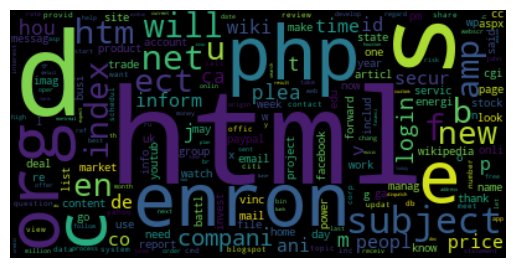

In [13]:
# Create the word cloud of words
text = ' '.join(df['text_sent'].tolist())
wordcloud = WordCloud(collocations=False).generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pipeline

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

In [15]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()

In [16]:
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

### Random Undersampling

In [17]:
# Separate the majority and minority classes
majority_class = df[df['Label'] == 1]
minority_class = df[df['Label'] == 0]

# Undersample the majority class
undersampled_majority_class = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the rows of the combined dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

# Reset the index
undersampled_df = undersampled_df.reset_index(drop=True)
undersampled_df.sample(10)


,Content,Label,text_tokenized,text_stemmed,text_sent
154980,widenotions.com/bh7188,0,"[widenotions, com, bh]","[widenot, com, bh]",widenot com bh
267393,travel.yahoo.com/p-hotel-25138291-hyatt_place_...,1,"[travel, yahoo, com, p, hotel, hyatt, place, g...","[travel, yahoo, com, p, hotel, hyatt, place, g...",travel yahoo com p hotel hyatt place grand rap...
124406,spoke.com/info/c5lAJJC/MolsonCoorsBrewingCompany,1,"[spoke, com, info, c, lAJJC, MolsonCoorsBrewin...","[spoke, com, info, c, lajjc, molsoncoorsbrewin...",spoke com info c lajjc molsoncoorsbrewingcompani
163924,icehockey.wikia.com/wiki/1937_Stanley_Cup_Finals,1,"[icehockey, wikia, com, wiki, Stanley, Cup, Fi...","[icehockey, wikia, com, wiki, stanley, cup, fi...",icehockey wikia com wiki stanley cup final
41592,zharifsofiaexchanger.com/qbsd2cbd,0,"[zharifsofiaexchanger, com, qbsd, cbd]","[zharifsofiaexchang, com, qbsd, cbd]",zharifsofiaexchang com qbsd cbd
8855,cduniverse.com/productinfo.asp?pid=7689035,1,"[cduniverse, com, productinfo, asp, pid]","[cdunivers, com, productinfo, asp, pid]",cdunivers com productinfo asp pid
279073,hup.harvard.edu/catalog.php?isbn=9780674058743,1,"[hup, harvard, edu, catalog, php, isbn]","[hup, harvard, edu, catalog, php, isbn]",hup harvard edu catalog php isbn
340628,Subject: re : hi ! !\n also meant to tell you ...,1,"[Subject, re, hi, also, meant, to, tell, you, ...","[subject, re, hi, also, meant, to, tell, you, ...",subject re hi also meant to tell you that nico...
334265,gamrreview.vgchartz.com/game/31689/demons-souls/,1,"[gamrreview, vgchartz, com, game, demons, souls]","[gamrreview, vgchartz, com, game, demon, soul]",gamrreview vgchartz com game demon soul
327306,tchorwacja.com/878hf33f34f,0,"[tchorwacja, com, hf, f, f]","[tchorwacja, com, hf, f, f]",tchorwacja com hf f f


In [18]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342012 entries, 0 to 342011
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Content         342012 non-null  object
 1   Label           342012 non-null  object
 2   text_tokenized  342012 non-null  object
 3   text_stemmed    342012 non-null  object
 4   text_sent       342012 non-null  object
dtypes: object(5)
memory usage: 13.0+ MB


In [19]:
under_label = undersampled_df.Label.values
under_label = under_label.astype('int')

# KFold cross_validate
n_folds = 10
kf = KFold(n_folds)

# LR Pipeline

Logistic Regression with TfidfVectorizer

In [20]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score
                                      # are parallelized over the cross-validation splits.

print_metrics(LR_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.955 [0.955, 0.955, 0.954, 0.956, 0.954, 0.955, 0.955, 0.957, 0.955, 0.957]
precision_ham   0.941 [0.94, 0.941, 0.94, 0.942, 0.939, 0.941, 0.94, 0.94, 0.941, 0.943]
recall_ham      0.972 [0.973, 0.971, 0.969, 0.972, 0.972, 0.972, 0.972, 0.975, 0.972, 0.973]
precision_spam  0.971 [0.971, 0.97, 0.969, 0.971, 0.971, 0.971, 0.971, 0.974, 0.97, 0.971]
recall_spam     0.939 [0.937, 0.938, 0.94, 0.94, 0.937, 0.939, 0.938, 0.939, 0.938, 0.941]

vocabulary size 415829.4
fit_time        46.0
score_time      1.0
188.8548562526703



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.94      0.95    171006
        Good       0.94      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

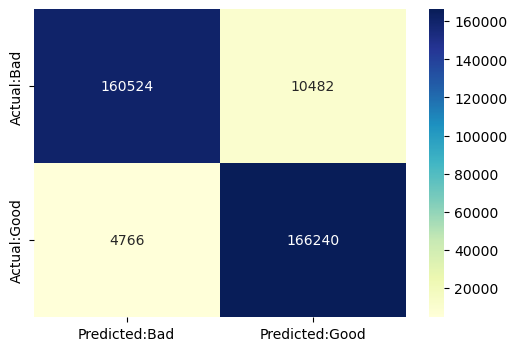

In [21]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Logistic Regression with CountVectorizer

In [22]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_cvect)

elapsed = time()-start
print(elapsed)

accuracy        0.96 [0.958, 0.961, 0.96, 0.961, 0.958, 0.957, 0.96, 0.961, 0.96, 0.96]
precision_ham   0.948 [0.945, 0.95, 0.948, 0.949, 0.948, 0.949, 0.948, 0.948, 0.948, 0.949]
recall_ham      0.972 [0.973, 0.974, 0.972, 0.974, 0.969, 0.967, 0.974, 0.975, 0.973, 0.972]
precision_spam  0.972 [0.972, 0.973, 0.972, 0.973, 0.969, 0.967, 0.974, 0.975, 0.972, 0.971]
recall_spam     0.947 [0.942, 0.948, 0.948, 0.948, 0.947, 0.948, 0.947, 0.947, 0.946, 0.948]

vocabulary size 415829.4
fit_time        52.0
score_time      1.0
164.2679419517517



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.95      0.96    171006
        Good       0.95      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

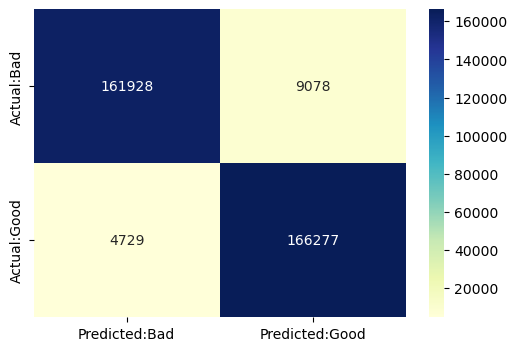

In [23]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Comparing Metrics with different Vectorizer
We compare the accuracy metric from LogisticRegression

In [24]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_accuracy'], 'LR_cvect': LR_cvect['test_accuracy']})
metrics

,LR_tfidf,LR_cvect
0,0.954856,0.957839
1,0.954915,0.960909
2,0.954446,0.959855
3,0.956229,0.960820
4,0.954475,0.958218
5,0.955381,0.957399
6,0.955264,0.960469
7,0.956726,0.960791
8,0.955031,0.959855
9,0.956668,0.959913


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

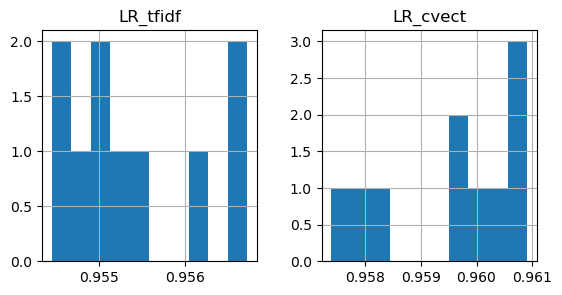

In [25]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

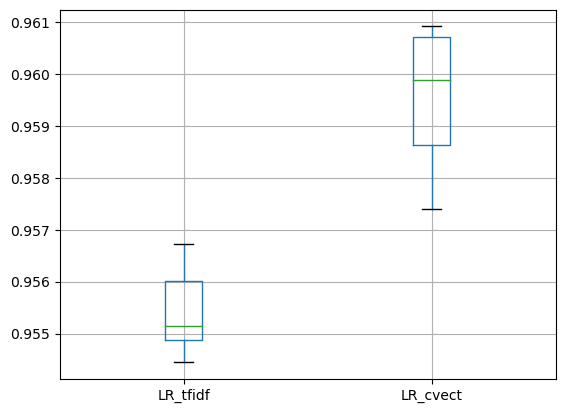

In [26]:
metrics.boxplot()

We compare the fscore_spam metric from LogisticRegression

In [27]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_fscore_spam'], 'LR_cvect': LR_cvect['test_fscore_spam']})
metrics

,LR_tfidf,LR_cvect
0,0.953700,0.956868
1,0.954061,0.960321
2,0.954163,0.959711
3,0.955514,0.960308
4,0.953846,0.957905
5,0.954659,0.957009
6,0.954554,0.959972
7,0.956192,0.960472
8,0.953916,0.958997
9,0.955809,0.959280


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

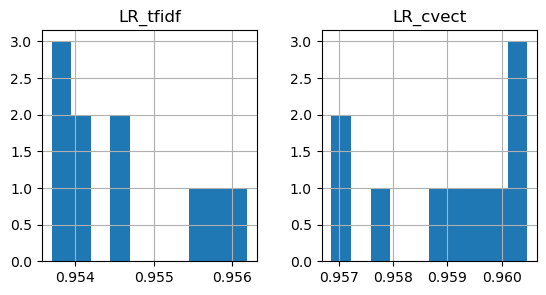

In [28]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

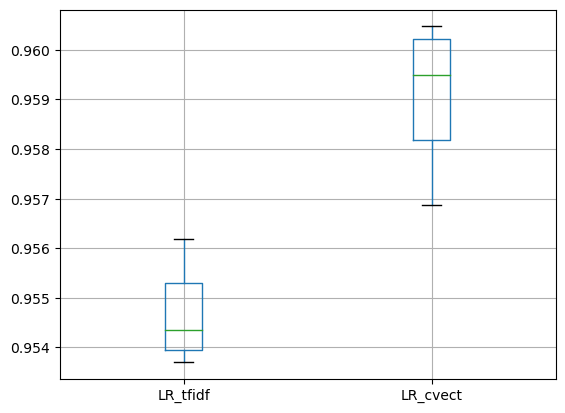

In [29]:
metrics.boxplot()

In [30]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.LR_tfidf,metrics.LR_cvect)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125


# SVC Pipeline

### SVC (with CountVectorizer)

In [31]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_cvect)

elapsed = time()-start
print(elapsed)

accuracy        0.976 [0.976, 0.976, 0.975, 0.975, 0.975, 0.976, 0.976, 0.976, 0.976, 0.976]
precision_ham   0.971 [0.971, 0.971, 0.97, 0.971, 0.971, 0.971, 0.969, 0.969, 0.971, 0.972]
recall_ham      0.981 [0.982, 0.981, 0.98, 0.98, 0.98, 0.981, 0.982, 0.983, 0.981, 0.981]
precision_spam  0.981 [0.982, 0.981, 0.98, 0.979, 0.98, 0.981, 0.982, 0.983, 0.981, 0.981]
recall_spam     0.97 [0.97, 0.971, 0.97, 0.97, 0.971, 0.97, 0.969, 0.969, 0.97, 0.971]

vocabulary size 415829.4
fit_time        98.0
score_time      1.0
385.01237440109253



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

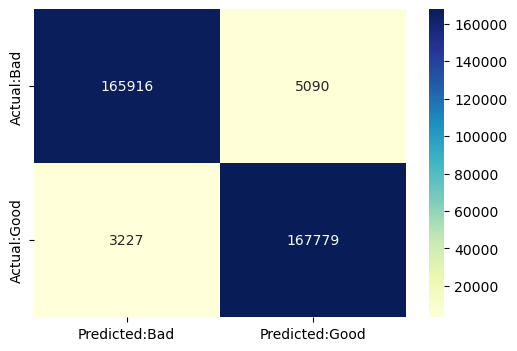

In [32]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### SVC (with TfidfVectorizer)

In [33]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.978 [0.977, 0.978, 0.977, 0.978, 0.978, 0.978, 0.977, 0.978, 0.978, 0.979]
precision_ham   0.972 [0.971, 0.973, 0.972, 0.973, 0.973, 0.972, 0.971, 0.97, 0.973, 0.974]
recall_ham      0.984 [0.984, 0.983, 0.983, 0.983, 0.983, 0.984, 0.984, 0.985, 0.983, 0.984]
precision_spam  0.983 [0.984, 0.983, 0.983, 0.983, 0.983, 0.984, 0.984, 0.985, 0.983, 0.984]
recall_spam     0.972 [0.97, 0.973, 0.972, 0.973, 0.973, 0.971, 0.971, 0.97, 0.972, 0.973]

vocabulary size 415829.4
fit_time        15.0
score_time      1.0
84.04416012763977



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

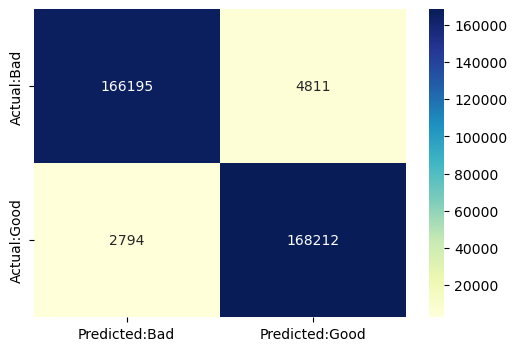

In [34]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# LR vs SVC

### Comparing Metrics with different Models
We compare the fscore_spam metrics from LogisticRegression and LinearSVC
FScore

In [35]:
metrics = pd.DataFrame({'LR':LR_cvect['test_fscore_spam'], 'SVC': SVC_cvect['test_fscore_spam']})
metrics

,LR,SVC
0,0.956868,0.975728
1,0.960321,0.975673
2,0.959711,0.975303
3,0.960308,0.974880
4,0.957905,0.975453
5,0.957009,0.975444
6,0.959972,0.975432
7,0.960472,0.976239
8,0.958997,0.975199
9,0.959280,0.976139


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

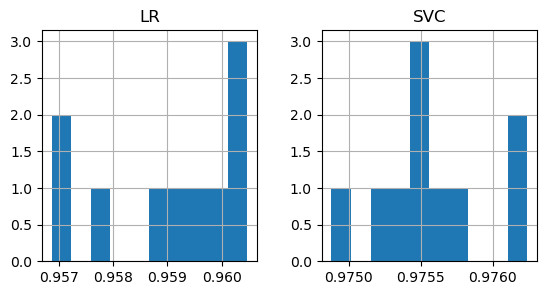

In [36]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

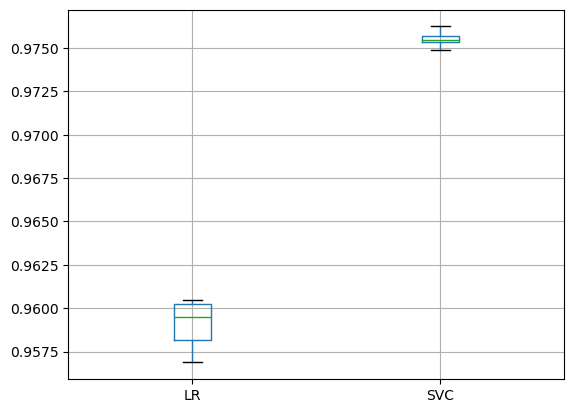

In [37]:
metrics.boxplot()

Accuracy metrics comparison 

In [38]:
metrics = pd.DataFrame({'LR':LR_cvect['test_accuracy'], 'SVC': SVC_cvect['test_accuracy']})
metrics

,LR,SVC
0,0.957839,0.976054
1,0.960909,0.975849
2,0.959855,0.975205
3,0.960820,0.975001
4,0.958218,0.975469
5,0.957399,0.975556
6,0.960469,0.975556
7,0.960791,0.976258
8,0.959855,0.975527
9,0.959913,0.976346


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

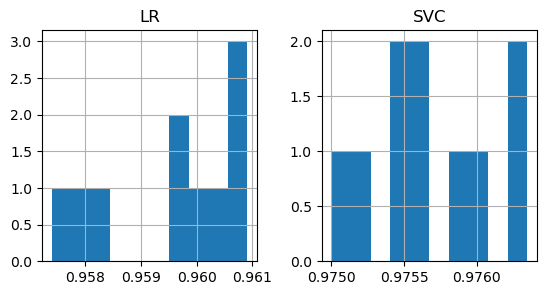

In [39]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

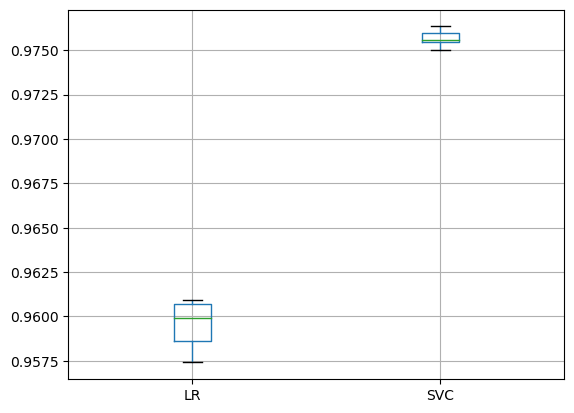

In [40]:
metrics.boxplot()

In [41]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.LR,metrics.SVC)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125


### SVC with Different Vectorizer: 
#### Counter vs Tfidf

Fscore metrics comparison

In [42]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_fscore_spam'], 'SVC_tfidf': SVC_tfidf['test_fscore_spam']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975728,0.976987
1,0.975673,0.977879
2,0.975303,0.977275
3,0.974880,0.977780
4,0.975453,0.978073
5,0.975444,0.977450
6,0.975432,0.977307
7,0.976239,0.977745
8,0.975199,0.977273
9,0.976139,0.978546


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

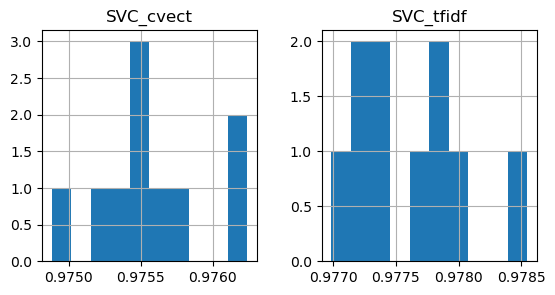

In [43]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

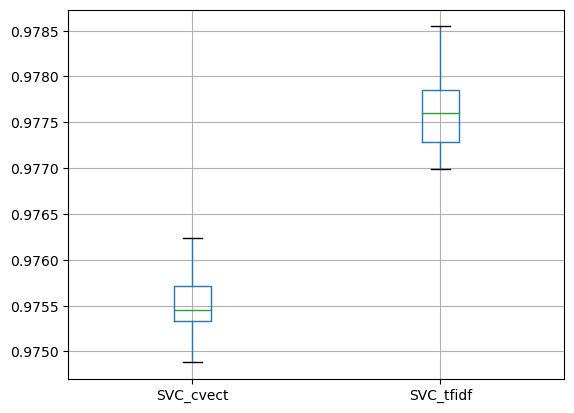

In [44]:
metrics.boxplot()

Accuracy metrics comparison

In [45]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_accuracy'], 'SVC_tfidf': SVC_tfidf['test_accuracy']})
metrics

,SVC_cvect,SVC_tfidf
0,0.976054,0.977311
1,0.975849,0.978042
2,0.975205,0.977194
3,0.975001,0.977895
4,0.975469,0.978100
5,0.975556,0.977574
6,0.975556,0.977428
7,0.976258,0.977778
8,0.975527,0.977574
9,0.976346,0.978743


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

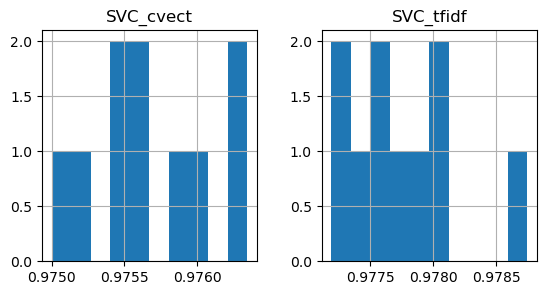

In [46]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

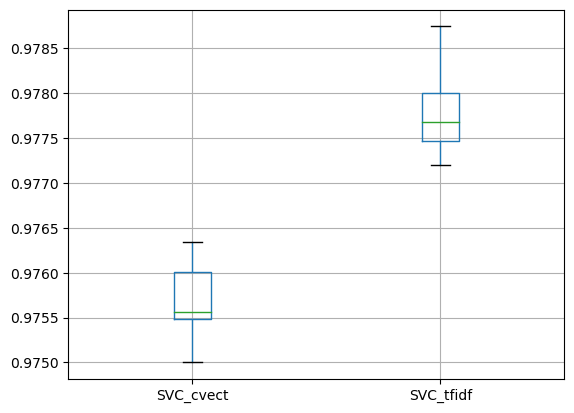

In [47]:
metrics.boxplot()

In [48]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.SVC_cvect,metrics.SVC_tfidf)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125
